# Immersic
> Generation of ambient music using a LSTM

- This project aims to be able to seamlessly generate ambient music, by training a LSTM model on a dataset of ambient music. The model will be able to generate music that is similar to the input dataset, but not identical. This will allow for the generation of new music that is unique, but still in the style of the input dataset.
- The dataset used for training is a collection of ambient music MIDI files, which can be found [here](https://github.com/nmtremblay/lofi-samples).

# Step 0: Preprocessing
- The first step is to preprocess the MIDI files in the dataset. This involves converting the MIDI files into a format that can be used by the model.
- Preprocessing is done in a separate notebook, due to the memory-intensive nature of the process.
- More info about this step can be found in the `Preprocessing.ipynb` notebook.

# Step 1: Import necessary libraries
- The main libraries used in this project are `music21` and `tensorflow`.
- `music21` is used to parse the MIDI files and extract the notes and chords.
- `tensorflow` is used to train the LSTM model.
- Other libraries needed are imported as shown below.


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
import os
import json
from pathlib import Path
from music21 import converter, instrument, note, chord, stream, pitch

# Step 2: Check if a GPU is available
- If a GPU is available, the code will use it for training the LSTM model (faster). Else, it will use the CPU by default.
- The code checks if a GPU is available, and memory growth is limited to grow only as needed.

In [ ]:
# Perform prerequisite checks
print(f"TensorFlow Version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs: {len(physical_devices)}")

if len(physical_devices) > 0:
    # Configure GPU growth (optional)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Available: True")
else:
    print("GPU Available: False")

TensorFlow Version: 2.10.1
Number of GPUs: 1
GPU Available: True


# Step 3: Use preprocessed data
- The preprocessed data is loaded from the `notes.json` file.
- The data is then processed to create the input and output sequences for the LSTM model.

In [ ]:
# Read the list from the file
with open('notes.json', 'r') as file:
    notes = json.load(file)

notes

['8.1',
 '3.4.8.11',
 'F#5',
 'B4',
 '6.11',
 '10.1.3.6',
 'F#5',
 'C#5',
 '8.1',
 '3.4.8.11',
 'F#5',
 'B4',
 '10.11.1.3.6',
 'G#3',
 '0.3.6.9',
 'G#5',
 'F#5',
 '6.9.11.1.2',
 '6.9.11.2',
 '11.2.4.7',
 '1.2.4.6.9',
 '6.9.11.1.2',
 '6.9.11.2',
 '11.2.4.7',
 '1.2.4.6.9',
 '6.9.11.1.2',
 '4.6.7.11',
 'G3',
 'E6',
 '7.11',
 'F#6',
 'E6',
 '6.7.11.2',
 '2.7',
 'B5',
 '7.9.1',
 '2.7',
 '6.7.11.1',
 '4.7',
 '6.7',
 '9.1.2',
 'F#6',
 '9.1',
 'F#6',
 '1.4.6.9',
 'A5',
 'E6',
 '9.1',
 '11.3',
 'A5',
 '11.3',
 '3.6.9.11',
 '1.3',
 'B5',
 '4.6.7.11',
 'G3',
 'E6',
 '7.11',
 'F#6',
 'E6',
 '6.7.11.2',
 '2.7',
 'B5',
 '7.9.1',
 '2.7',
 '6.7.11.1',
 '4.7',
 '6.7',
 '9.1.2',
 'F#6',
 '9.1',
 'F#6',
 '1.4.6.9',
 'A5',
 'E6',
 '9.1',
 '11.3',
 'A5',
 '11.3',
 '3.6.9.11',
 '1.3',
 'B5',
 '9.11.0.2.4',
 'E4',
 'G4',
 'E5',
 '11.2.4.6.7',
 'F#4',
 'E5',
 'B4',
 'G5',
 '9.11.0.2.4',
 'E4',
 'G4',
 'E5',
 '11.2.4.6.7',
 'F#4',
 'E5',
 'G5',
 '6.7.11.2',
 'B4',
 'G4',
 'D4',
 '4.5.9.0',
 'D5',
 'G5',
 'G4',

In [ ]:
# Prepare the sequences used by the neural network
def prepare_sequences(notes, n_notes):
    sequence_length = 32
    # Get all unique pitchnames
    pitchnames = sorted(set(item for item in notes))
    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]

        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    print(len(network_input))

    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_notes)

    network_output = to_categorical(network_output)

    return (network_input, network_output)

In [ ]:
# Define variables to be used by the model
n_notes = len(set(notes))
network_input, network_output = prepare_sequences(notes,n_notes)
pitchnames = sorted(set(item for item in notes))
numPitches = len(pitchnames)

pitchnames

4547


['0',
 '0.1.3.5.8',
 '0.1.5.8',
 '0.2',
 '0.2.3.5.7',
 '0.2.3.7',
 '0.2.4',
 '0.2.4.7',
 '0.2.4.7.9',
 '0.2.5',
 '0.2.7',
 '0.3',
 '0.3.5',
 '0.3.5.7',
 '0.3.5.7.8',
 '0.3.5.8',
 '0.3.6',
 '0.3.6.9',
 '0.3.7',
 '0.4',
 '0.4.5',
 '0.4.5.7',
 '0.4.6',
 '0.4.7',
 '0.4.7.8',
 '0.4.8',
 '0.5',
 '0.6',
 '1',
 '1.2',
 '1.2.4',
 '1.2.4.6.9',
 '1.2.5',
 '1.2.6',
 '1.2.6.9',
 '1.3',
 '1.3.4.8',
 '1.3.5',
 '1.3.6',
 '1.3.6.9',
 '1.3.8',
 '1.4',
 '1.4.6',
 '1.4.6.8.9',
 '1.4.6.9',
 '1.4.7',
 '1.4.8',
 '1.5',
 '1.5.6.8',
 '1.5.8',
 '1.6',
 '1.7',
 '10',
 '10.0',
 '10.0.1.5',
 '10.0.2',
 '10.0.2.3.5.7',
 '10.0.2.5',
 '10.0.2.5.7',
 '10.0.3',
 '10.0.5',
 '10.1',
 '10.1.3.5.6',
 '10.1.3.6',
 '10.1.4',
 '10.1.5',
 '10.11.1.3.6',
 '10.11.3.6',
 '10.2',
 '10.2.3.5',
 '10.2.5',
 '10.3',
 '11',
 '11.0',
 '11.0.2',
 '11.0.2.4.7',
 '11.0.2.6',
 '11.0.3.6',
 '11.0.4',
 '11.0.4.7',
 '11.1',
 '11.1.2.6',
 '11.1.3',
 '11.1.3.6',
 '11.1.4.7',
 '11.1.5',
 '11.1.6',
 '11.2',
 '11.2.3.5',
 '11.2.4',
 '11.2.4.6.7',
 

# Step 4: Analysis of training data
- The training data is analyzed to get an idea of the number of unique notes and chords in the dataset.
- Plots of the notes' distributions and velocities are created to further understand the dataset.

In [ ]:
def analyze_midi_file(file_path):
    midi_stream = converter.parse(file_path)

    # Initialize variables for analysis
    note_distribution = {}
    pitch_distribution = {}
    note_duration_distribution = {}
    chord_analysis = {}
    key_signature_distribution = {}
    time_signature_distribution = {}
    note_velocity_distribution = {}
    total_notes = 0

    # Iterate over notes in the MIDI file
    for element in midi_stream.flat:
        if 'Note' in element.classes:
            total_notes += 1
            # Note Distribution
            note_name = element.pitch.name
            note_distribution[note_name] = note_distribution.get(note_name, 0) + 1
            # Pitch Distribution
            pitch_name = element.pitch.ps
            pitch_distribution[pitch_name] = pitch_distribution.get(pitch_name, 0) + 1
            # Note Duration Distribution
            note_duration = element.duration.quarterLength
            note_duration_distribution[note_duration] = note_duration_distribution.get(note_duration, 0) + 1
            # Note Velocity Distribution
            note_velocity = element.volume.velocity
            note_velocity_distribution[note_velocity] = note_velocity_distribution.get(note_velocity, 0) + 1
        elif 'Chord' in element.classes:
            # Chord Analysis
            chord_name = ' '.join(pitch.Pitch(n).name for n in element.pitches)
            chord_analysis[chord_name] = chord_analysis.get(chord_name, 0) + 1

    # Key Signature Distribution
    key_signature = midi_stream.analyze('key')
    key_signature_distribution[key_signature.tonic.name] = key_signature_distribution.get(key_signature.tonic.name, 0) + 1
    # Time Signature Distribution
    time_signature = midi_stream.getTimeSignatures()[0].ratioString
    time_signature_distribution[time_signature] = time_signature_distribution.get(time_signature, 0) + 1

    # Calculate percentages for distributions
    note_distribution_percentage = {note: (count / total_notes) * 100 for note, count in note_distribution.items()}
    pitch_distribution_percentage = {pitch: (count / total_notes) * 100 for pitch, count in pitch_distribution.items()}
    note_duration_distribution_percentage = {duration: (count / total_notes) * 100 for duration, count in note_duration_distribution.items()}
    note_velocity_distribution_percentage = {velocity: (count / total_notes) * 100 for velocity, count in note_velocity_distribution.items()}

    return {
        'Note Distribution': note_distribution_percentage,
        'Pitch Distribution': pitch_distribution_percentage,
        'Note Duration Distribution': note_duration_distribution_percentage,
        'Chord Analysis': chord_analysis,
        'Key Signature Distribution': key_signature_distribution,
        'Time Signature Distribution': time_signature_distribution,
        'Note Velocity Distribution': note_velocity_distribution_percentage
    }

In [ ]:
def analyze_midi_folder(folder_path):
    # Initialize variables for aggregate analysis
    aggregate_analysis = {
        'Note Distribution': {},
        'Pitch Distribution': {},
        'Note Duration Distribution': {},
        'Chord Analysis': {},
        'Key Signature Distribution': {},
        'Time Signature Distribution': {},
        'Note Velocity Distribution': {}
    }
    total_files = 0

    # Loop through all MIDI files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mid"):
            total_files += 1
            file_path = os.path.join(folder_path, file_name)
            analysis_result = analyze_midi_file(file_path)

            # Aggregate analysis results
            for key, value in analysis_result.items():
                if isinstance(value, dict):
                    if key in aggregate_analysis:
                        for item_key, item_value in value.items():
                            aggregate_analysis[key][item_key] = aggregate_analysis[key].get(item_key, 0) + item_value
                    else:
                        aggregate_analysis[key] = value
                else:
                    aggregate_analysis[key] = aggregate_analysis.get(key, 0) + value

    # Calculate average percentages for distributions
    for key in aggregate_analysis.keys():
        if isinstance(aggregate_analysis[key], dict):
            for item_key in aggregate_analysis[key].keys():
                aggregate_analysis[key][item_key] /= total_files
        else:
            aggregate_analysis[key] /= total_files

    return aggregate_analysis

In [ ]:
folder = Path('Data\\Random_Archive')
aggregate_result = analyze_midi_folder(folder)

In [ ]:
def plot_distribution(data, title):
    plt.bar(data.keys(), data.values())
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.show()

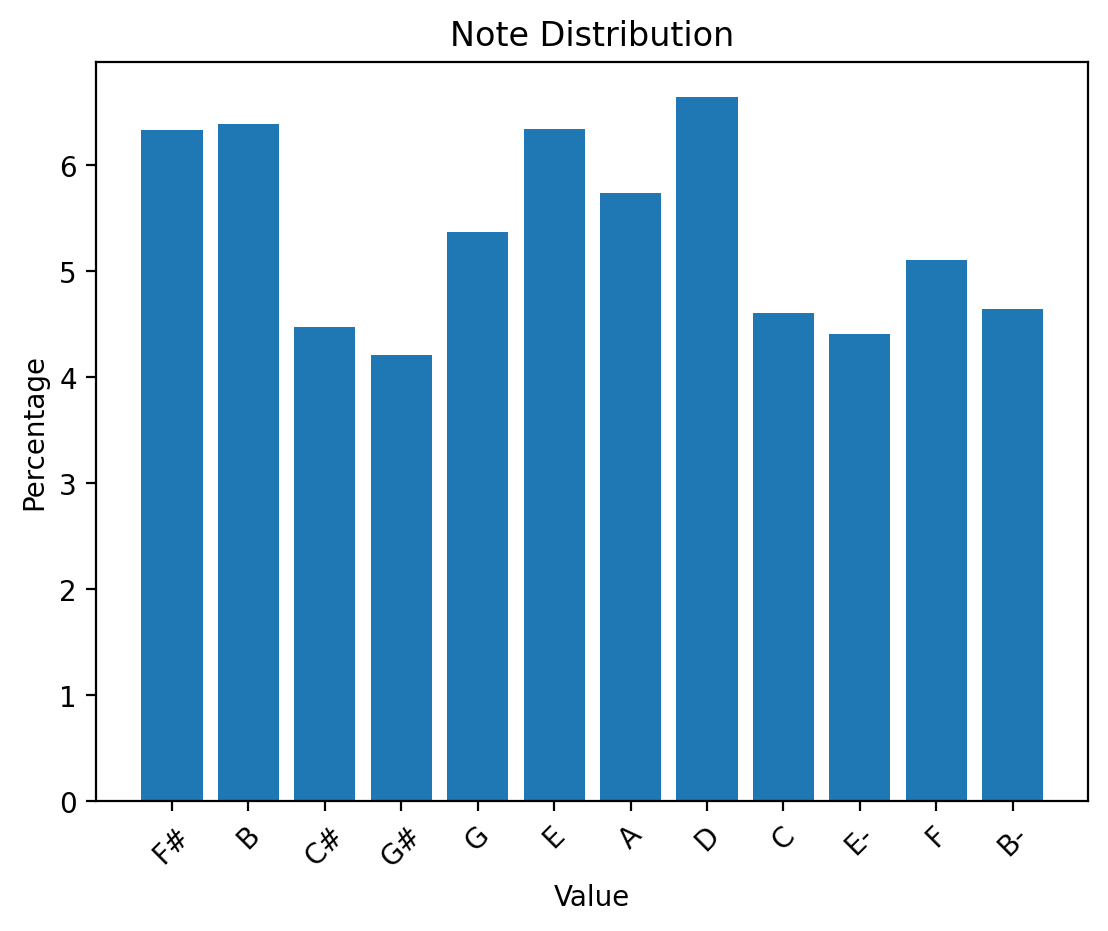

In [ ]:
plot_distribution(aggregate_result['Note Distribution'], "Note Distribution")

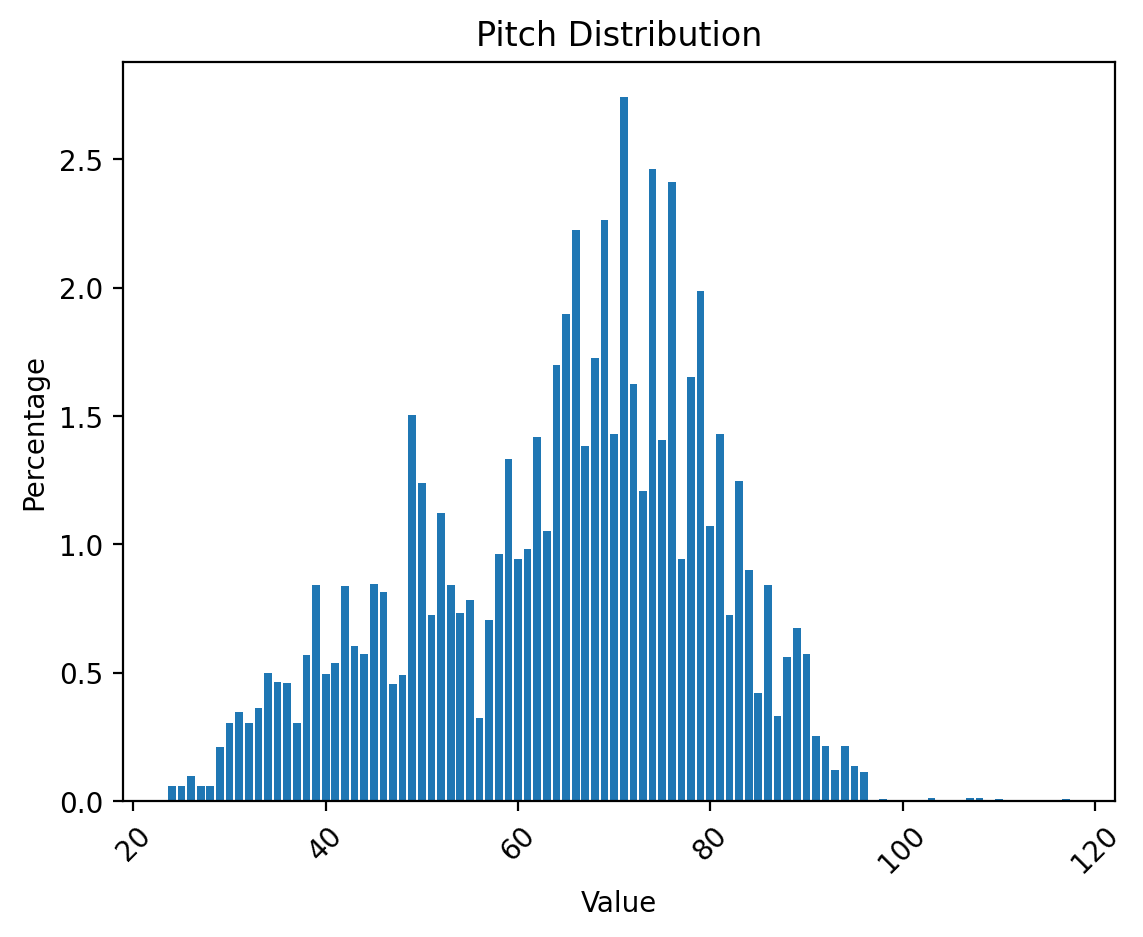

In [ ]:
plot_distribution(aggregate_result['Pitch Distribution'], "Pitch Distribution")

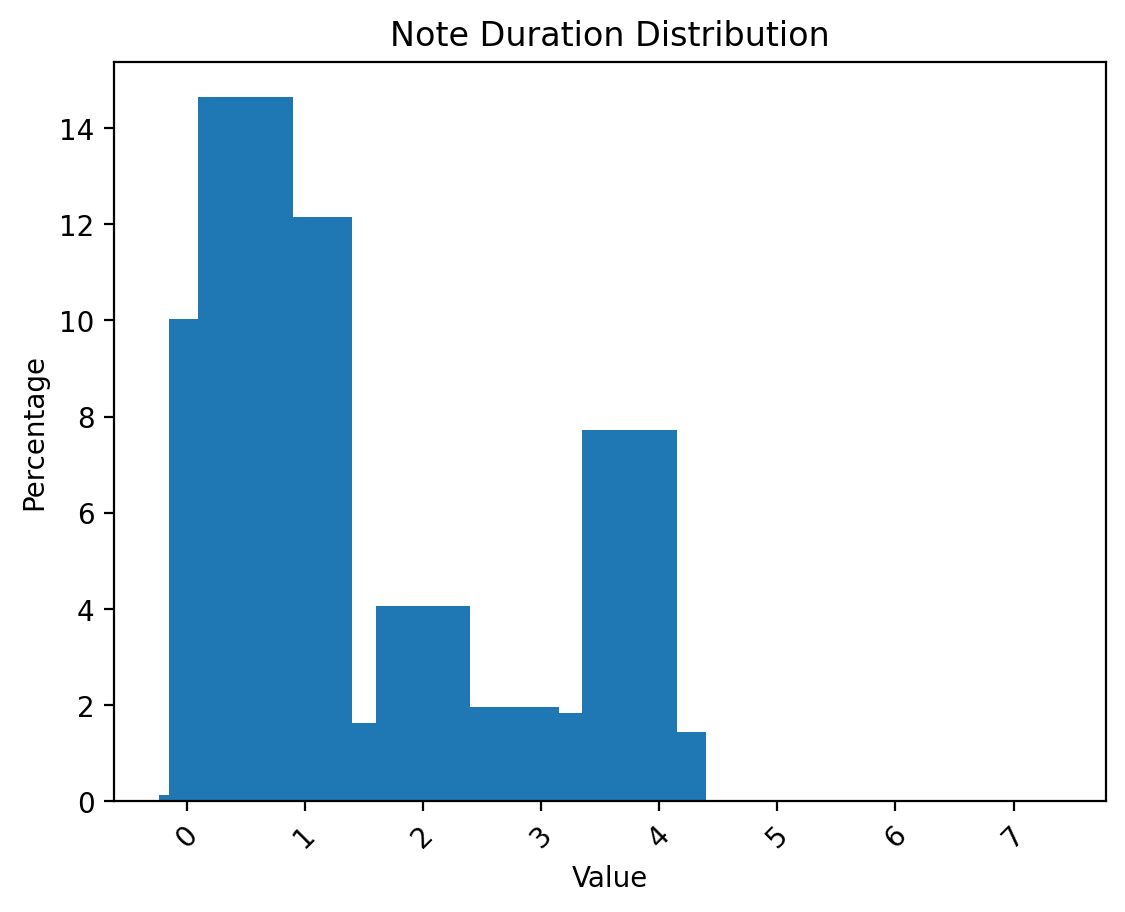

In [ ]:
plot_distribution(aggregate_result['Note Duration Distribution'], "Note Duration Distribution")

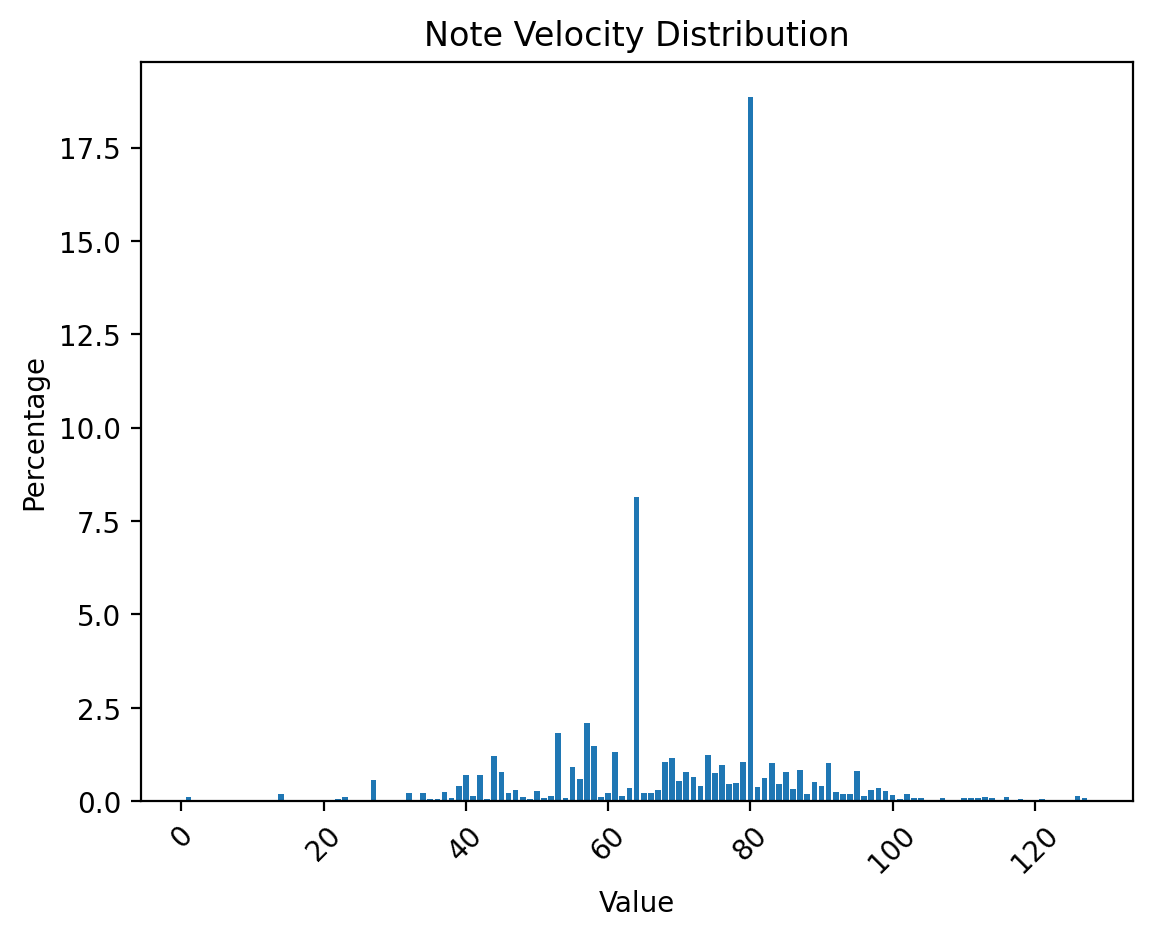

In [ ]:
plot_distribution(aggregate_result['Note Velocity Distribution'], "Note Velocity Distribution")

# Step 5: Create the LSTM model
- The neural network is created with Dropout, LSTM, Dense and Activation layers.
- The LSTM layer is created using the `tensorflow.keras` API.
- The overall model uses checkpoints to save the weights of the model during training, and early stopping to prevent overfitting.


In [ ]:
# Create the model
model = Sequential()
model.add(Dropout(0.2))
model.add(LSTM(
    128,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dense(64))
model.add(Dense(64))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(64))
model.add(LSTM(128))
model.add(Dense(numPitches))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
num_epochs = 500

filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger_1.keras"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
with tf.device('/GPU:0'):
    history = model.fit(network_input, network_output, epochs=num_epochs, batch_size=64, callbacks=callbacks_list)

Epoch 1/500
71/72 [============================>.] - ETA: 0s - loss: 5.4256 - accuracy: 0.0222
Epoch 1: loss improved from inf to 5.42579, saving model to weights-improvement-01-5.4258-bigger_1.keras
72/72 [==============================] - 21s 65ms/step - loss: 5.4258 - accuracy: 0.0222
Epoch 2/500
72/72 [==============================] - ETA: 0s - loss: 5.2768 - accuracy: 0.0235
Epoch 2: loss improved from 5.42579 to 5.27680, saving model to weights-improvement-02-5.2768-bigger_1.keras
72/72 [==============================] - 5s 63ms/step - loss: 5.2768 - accuracy: 0.0235
Epoch 3/500
71/72 [============================>.] - ETA: 0s - loss: 5.1982 - accuracy: 0.0315
Epoch 3: loss improved from 5.27680 to 5.19881, saving model to weights-improvement-03-5.1988-bigger_1.keras
72/72 [==============================] - 5s 63ms/step - loss: 5.1988 - accuracy: 0.0314
Epoch 4/500
71/72 [============================>.] - ETA: 0s - loss: 5.1528 - accuracy: 0.0295
Epoch 4: loss improved from 5.19

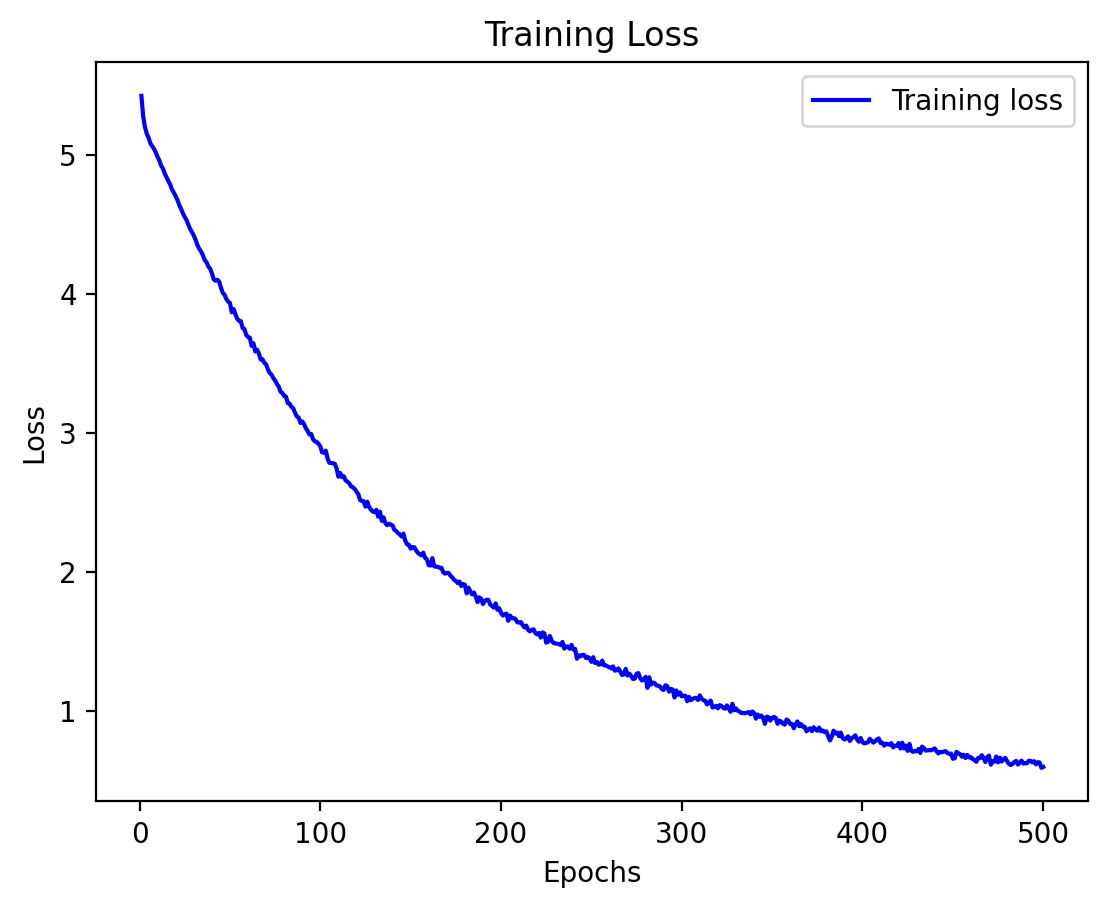

In [ ]:
# Plot the loss over time
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
save_path = 'Data\\Samples'

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + '/loss.png')
plt.show()

# Step 6: Generate music
- After the model is trained, it can be used to generate music.
- The model generates music by predicting the next note in the sequence, based on the input sequence. This process is started by picking a random sequence from the network's input data.

In [ ]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    # Select a random row from the network_input
    start = np.random.randint(0, len(network_input)-1)
    print(f'start: {start}')
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    for note_index in range(500):

        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]

        prediction_output.append(result)

        pattern = np.append(pattern,index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

n_notes = len(set(notes))
pitchnames = sorted(set(item for item in notes))
prediction_output = generate_notes(model, network_input, pitchnames, n_notes)

start: 36


# Step 7: Create a MIDI file
- The generated music is then saved as a file containing MIDI sequences, which can then be played locally on your machine.
- The `music21` library is again used to create the MIDI file from the generated notes.

In [ ]:
# Create a MIDI file from the predicted notes
def create_midi(prediction_output):
    offset = 0
    output_notes = []

    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        if ("." in pattern) or pattern.isdigit(): # If pattern is a chord
            notes_in_chord = pattern.split(".")
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else: # If pattern is a note
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Increase the offset in each iteration, so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write("midi", fp="generated.mid")

In [ ]:
create_midi(prediction_output)